In [1]:
import numpy as np
import pandas as pd
import types
import sys
from collections import defaultdict
from pprint import pformat
import math

from pyqstrat.evaluator import compute_return_metrics, display_return_metrics, plot_return_metrics
from pyqstrat.account import Account
from pyqstrat.pq_utils import *
from pyqstrat.pq_types import ContractGroup
from pyqstrat.plot import TimeSeries, trade_sets_by_reason_code, Subplot, Plot

order_qty: 2090.0 curr_equity: 1000000.0 timestamp: 2019-01-23T11:15:00.000000000 risk_percent: 0.1 indicator: 47.84 signal_value: 2
order_qty: -912.0 curr_equity: 1000000.0 timestamp: 2019-01-23T11:15:00.000000000 risk_percent: 0.1 indicator: 109.63 signal_value: -2.0
trade: KO 2019-01-23 11:30:00 qty: 2090.0 prc: 47.87 order: KO 2019-01-23 11:15:00 qty: 2090.0 enter long filled
trade: PEP 2019-01-23 11:30:00 qty: -912.0 prc: 109.585 order: PEP 2019-01-23 11:15:00 qty: -912.0 enter short filled
trade: KO 2019-01-25 11:15:00 qty: -2090.0 prc: 47.6225 order: KO 2019-01-25 11:00:00 qty: -2090.0 exit long filled
trade: PEP 2019-01-25 11:15:00 qty: 912.0 prc: 110.337 order: PEP 2019-01-25 11:00:00 qty: 912.0 exit short filled
order_qty: -2119.0 curr_equity: 999314.176 timestamp: 2019-01-28T09:45:00.000000000 risk_percent: 0.1 indicator: 47.155 signal_value: -2
order_qty: 915.0 curr_equity: 999314.176 timestamp: 2019-01-28T09:45:00.000000000 risk_percent: 0.1 indicator: 109.2107 signal_valu

<Figure size 432x288 with 0 Axes>

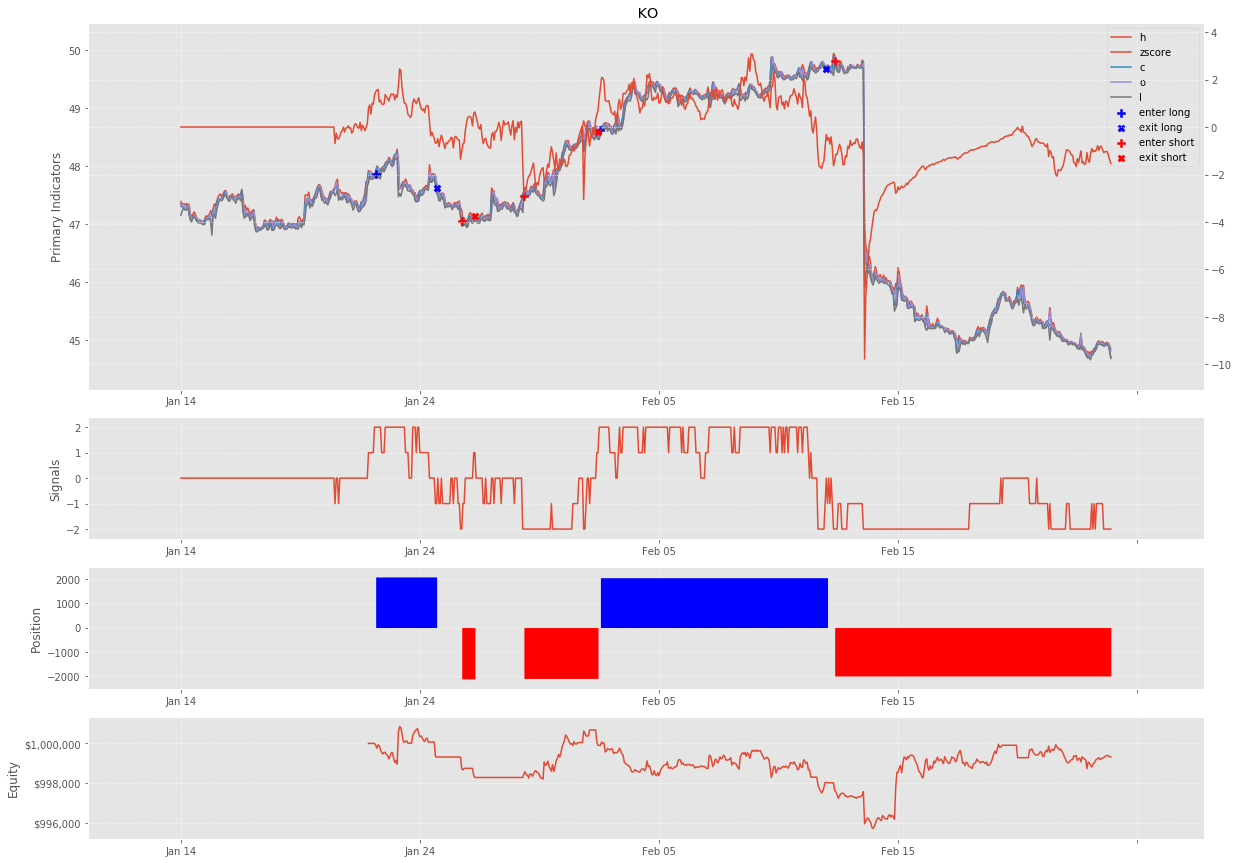

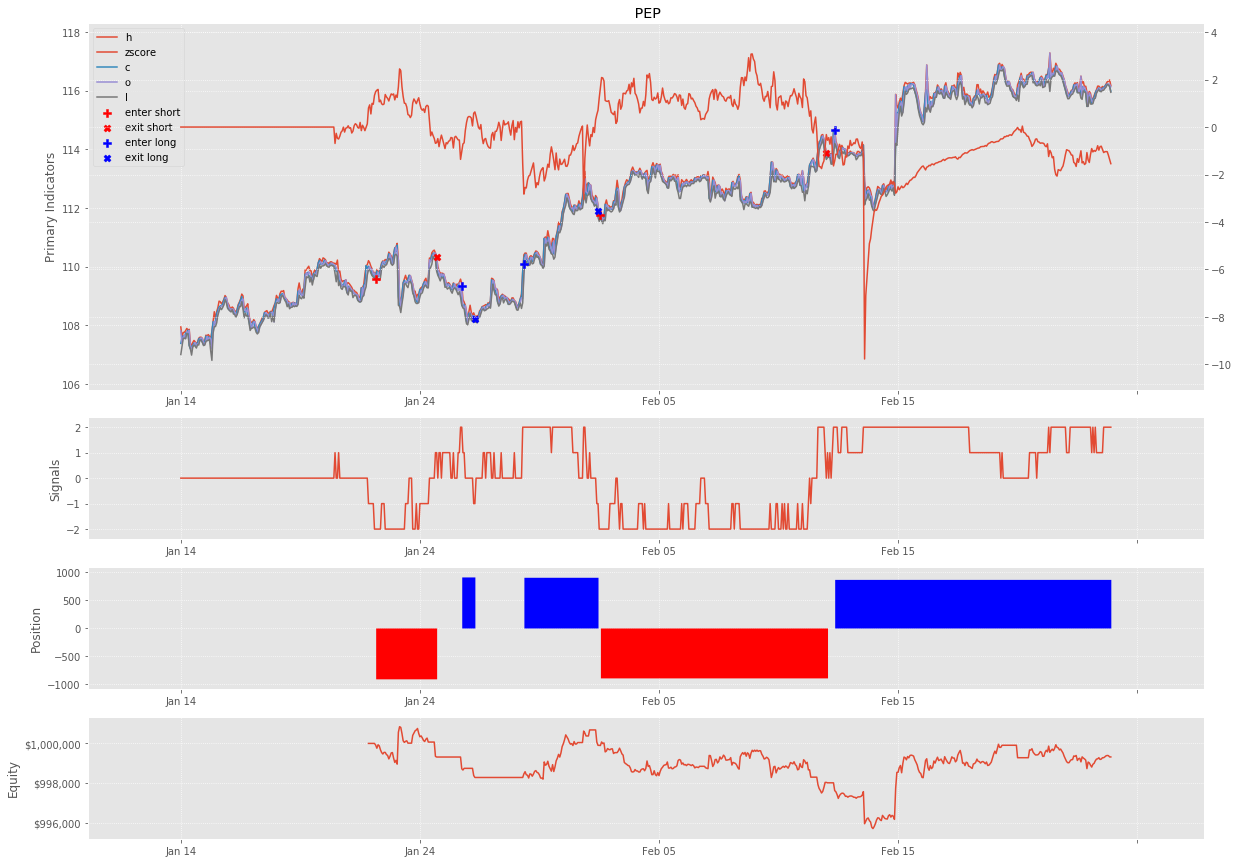

In [2]:
def _get_time_series_list(timestamps, names, values, properties):
    ts_list = []
    for name in names:
        line_type, color = None, None
        if properties is not None and name in properties:
            if 'line_type' in properties[name]: line_type = properties[name]['line_type']
            if 'color' in properties[name]: color = properties[name]['color']
        y = getattr(values, name)
        if not len(y): continue
        if y.dtype.type in [np.str_, np.object_, np.datetime64]: continue
        ts = TimeSeries(name, timestamps, y, line_type = line_type, color = color)
        ts_list.append(ts)
    return ts_list

class Strategy:
    def __init__(self, timestamps, contract_groups, price_function, starting_equity = 1.0e6, calc_frequency = 'D', 
                 strategy_context = None, exclude_order_timestamps = None, exclude_trade_timestamps = None):
        '''
        Args:
            timestamps (np.array of np.datetime64): The "heartbeat" of the strategy.  We will evaluate trading rules and 
                simulate the market at these times.
            price_function: A function that returns the price of a contract at a given timestamp
            contract_groups (list of :obj:`ContractGroup`): The contract groups we will potentially trade.
            starting_equity (float, optional): Starting equity in Strategy currency.  Default 1.e6
            calc_frequency (str, optional): How often P&L is calculated.  Default is 'D' for daily
            exclude_order_timestamps (np.array of np.datetime64, optional): Don't evaluate trade rules at these times.  
                Default None
            strategy_context (:obj:`types.SimpleNamespace`, optional): A storage class where you can store key / value pairs 
                relevant to this strategy.  For example, you may have a pre-computed table of correlations that you use in the 
                indicator or trade rule functions.  
                If not set, the __init__ function will create an empty member strategy_context object that you can access.
            exclude_trade_timestamps (np.array of np.datetime64, optional): Don't evaluate market simulators at these times.  
                Default None
        '''
        self.name = None
        self.timestamps = timestamps
        assert(len(contract_groups)) and isinstance(contract_groups[0], ContractGroup)
        self.contract_groups = contract_groups
        if strategy_context is None: strategy_context = types.SimpleNamespace()
        self.strategy_context = strategy_context
        self.account = Account(contract_groups, timestamps, price_function, strategy_context, starting_equity, calc_frequency)
        self.exclude_order_timestamps = exclude_order_timestamps
        self.exclude_trade_timestamps = exclude_trade_timestamps
        self.indicators = {}
        self.signals = {}
        self.signal_values = defaultdict(types.SimpleNamespace)
        self.rules = {}
        self.rule_types = {}
        self.rule_signals = {}
        self.market_sims = {}
        self._trades = defaultdict(list)
        self._orders = []
        self.indicator_deps = {}
        self.indicator_cgroups = {}
        self.indicator_values = defaultdict(types.SimpleNamespace)
        self.signal_indicator_deps = {}
        self.signal_deps = {}
        self.signal_cgroups = {}
        
    def add_indicator(self, name, indicator, contract_groups = None, depends_on = None):
        '''
        Args:
            name: Name of the indicator
            indicator:  A function that takes strategy timestamps and other indicators and returns a numpy array
              containing indicator values.  The return array must have the same length as the timestamps object.
              Can also be a numpy array or a pandas Series in which case we just store the values.
            contract_groups (list of :obj:`ContractGroup', optional): Contract groups that this indicator applies to.  
                If not set, it applies to all contract groups.  Default None.
            depends_on (list of str, optional): Names of other indicators that we need to compute this indicator.
                Default None.
        '''
        self.indicators[name] = indicator
        self.indicator_deps[name] = [] if depends_on is None else depends_on
        if contract_groups is None: contract_groups = self.contract_groups
        if isinstance(indicator, np.ndarray) or isinstance(indicator, pd.Series):
            indicator_values = series_to_array(indicator)
            for contract_group in contract_groups:
                setattr(self.indicator_values[contract_group], name, indicator_values)
        self.indicator_cgroups[name] = contract_groups
        
    def add_signal(self, name, signal_function, contract_groups = None, depends_on_indicators = None, depends_on_signals = None):
        '''
        Args:
            name (str): Name of the signal
            signal_function (function):  A function that takes timestamps and a dictionary of indicator value arrays and 
                returns a numpy array
                containing signal values.  The return array must have the same length as the input timestamps
            contract_groups (list of :obj:`ContractGroup', optional): Contract groups that this signal applies to.  
                If not set, it applies to all contract groups.  Default None.
            depends_on_indicators (list of str, optional): Names of indicators that we need to compute this signal. Default None.
            depends_on_signals (list of str, optional): Names of other signals that we need to compute this signal. Default None.
        '''
        self.signals[name] = signal_function
        self.signal_indicator_deps[name] = [] if depends_on_indicators is None else depends_on_indicators
        self.signal_deps[name] = [] if depends_on_signals is None else depends_on_signals
        if contract_groups is None: contract_groups = self.contract_groups
        self.signal_cgroups[name] = contract_groups
        
    def add_rule(self, name, rule_function, signal_name, sig_true_values = None, rule_type = None):
        '''Add a trading rule
        
        Args:
            name (str): Name of the trading rule
            rule_function (function): A trading rule function that returns a list of Orders
            signal_name (str): The strategy will call the trading rule function when the signal with this name matches sig_true_values
            sig_true_values (numpy array, optional): If the signal value at a bar is equal to one of these values, 
                the Strategy will call the trading rule function.  Default [TRUE]
            rule_type (str, optional): Can be "entry", "exit" or None.  Entry rules are only triggered when 
                the corresponding contract positions are 0
                exit rules are only triggered when the corresponding contract positions are non-zero.  
                If not set, we don't look at position before triggering the rule.
                Default None
        '''
        if sig_true_values is None: sig_true_values = [True]
        self.rule_signals[name] = (signal_name, sig_true_values)
        self.rules[name] = rule_function
        if rule_type is not None:
            assert(rule_type in ['entry', 'exit'])
        self.rule_types[name] = rule_type
        
    def add_market_sim(self, market_sim_function, contract_groups = None):
        '''Add a market simulator.  A market simulator takes a list of Orders as input and returns a list of Trade objects.
        
        Args:
            market_sim_function (function): A function that takes a list of Orders and Indicators as input 
                and returns a list of Trade objects
            contract_groups (list of :obj:`ContractGroup', optional): Contract groups that this simulator applies to.  
                If not set, it applies to all contract groups.  Default None.

        '''
        if contract_groups is None: contract_groups = self.contract_groups
        for contract_group in contract_groups: self.market_sims[contract_group] = market_sim_function
        
    def run_indicators(self, indicator_names = None, contract_groups = None, clear_all = False):
        '''Calculate values of the indicators specified and store them.
        
        Args:
            indicator_names (list of str, optional): List of indicator names.  If None (default) run all indicators
            contract_groups (list of :obj:`ContractGroup', optional): Contract group to run this indicator for.  
                If None (default), we run it for all contract groups.
            clear_all (bool, optional): If set, clears all indicator values before running.  Default False.
        '''
        if indicator_names is None: indicator_names = self.indicators.keys()
        if contract_groups is None: contract_groups = self.contract_groups
            
        if clear_all:  self.indicator_values = defaultdict(types.SimpleNamespace)
            
        ind_names = []
            
        for ind_name, cgroup_list in self.indicator_cgroups.items():
            if len(set(contract_groups).intersection(cgroup_list)): ind_names.append(ind_name)
                
        indicator_names = list(set(ind_names).intersection(indicator_names))
         
        for cgroup in contract_groups:
            cgroup_ind_namespace = self.indicator_values[cgroup]
            for indicator_name in indicator_names:
                # First run all parents
                parent_names = self.indicator_deps[indicator_name]
                for parent_name in parent_names:
                    if cgroup in self.indicator_values and hasattr(cgroup_ind_namespace, parent_name): continue
                    self.run_indicators([parent_name], [cgroup])
                    
                # Now run the actual indicator
                if cgroup in self.indicator_values and hasattr(cgroup_ind_namespace, indicator_name): continue
                indicator_function = self.indicators[indicator_name]
                     
                parent_values = types.SimpleNamespace()

                for parent_name in parent_names:
                    setattr(parent_values, parent_name, getattr(cgroup_ind_namespace, parent_name))

                setattr(cgroup_ind_namespace, indicator_name, series_to_array(
                    indicator_function(cgroup, self.timestamps, parent_values, self.strategy_context)))
                
    def run_signals(self, signal_names = None, contract_groups = None, clear_all = False):
        '''Calculate values of the signals specified and store them.
        
        Args:
            signal_names (list of str, optional): List of signal names.  If None (default) run all signals
            contract_groups (list of :obj:`ContractGroup', optional): Contract groups to run this signal for.  
                If None (default), we run it for all contract groups.
            clear_all (bool, optional): If set, clears all signal values before running.  Default False.
        '''
        if signal_names is None: signal_names = self.signals.keys()
        if contract_groups is None: contract_groups = self.contract_groups
            
        if clear_all: self.signal_values = defaultdict(types.SimpleNamespace)
            
        sig_names = []
        
        for sig_name, cgroup_list in self.signal_cgroups.items():
            if len(set(contract_groups).intersection(cgroup_list)): sig_names.append(sig_name)
                
        signal_names = list(set(sig_names).intersection(signal_names))
        
        for cgroup in contract_groups:
            for signal_name in signal_names:
                # First run all parent signals
                parent_names = self.signal_deps[signal_name]
                for parent_name in parent_names:
                    if cgroup in self.signal_values and hasattr(self.signal_values[cgroup], parent_name): continue
                    self.run_signals([parent_name], [cgroup])
                # Now run the actual signal
                if cgroup in self.signal_values and hasattr(self.signal_values[cgroup], signal_name): continue
                signal_function = self.signals[signal_name]
                parent_values = types.SimpleNamespace()
                for parent_name in parent_names:
                    setattr(parent_values, parent_name, getattr(self.signal_values[cgroup], parent_name))
                    
                # Get indicators needed for this signal
                indicator_values = types.SimpleNamespace()
                for indicator_name in self.signal_indicator_deps[signal_name]:
                    setattr(indicator_values, indicator_name, getattr(self.indicator_values[cgroup], indicator_name))
                    
                setattr(self.signal_values[cgroup], signal_name, series_to_array(
                    signal_function(cgroup, self.timestamps, indicator_values, parent_values, self.strategy_context)))
                
    def run_rules(self, rule_names = None, contract_groups = None, start_date = None, end_date = None):
        '''Run trading rules.
        
        Args:
            rule_names: List of rule names.  If None (default) run all rules
            contract_groups (list of :obj:`ContractGroup', optional): Contract groups to run this rule for.  
                If None (default), we run it for all contract groups.
            start_date: Run rules starting from this date. Default None 
            end_date: Don't run rules after this date.  Default None
        '''
        start_date, end_date = str2date(start_date), str2date(end_date)
        timestamps, orders_iter, trades_iter = self._get_iteration_indices(rule_names, contract_groups, start_date, end_date)
        # Now we know which rules, contract groups need to be applied for each iteration, go through each iteration and apply them
        # in the same order they were added to the strategy
        for i, tup_list in enumerate(orders_iter):
            timestamp = self.timestamps[i]
            if timestamp not in self.exclude_trade_timestamps:
                self._check_for_trades(i, trades_iter[i])
                self.account.calc(idx)
            if timestamp not in self.exclude_order_timestamps:
                self._check_for_orders(i, tup_list)


        
    def _get_iteration_indices(self, rule_names = None, contract_groups = None, start_date = None, end_date = None):
        '''
        >>> class MockStrat:
        ...    def __init__(self):
        ...        self.timestamps = timestamps
        ...        self.account = self
        ...        self.rules = {'rule_a' : rule_a, 'rule_b' : rule_b}
        ...        self.market_sims = {ibm : market_sim_ibm, aapl : market_sim_aapl}
        ...        self.rule_signals = {'rule_a' : ('sig_a', [1]), 'rule_b' : ('sig_b', [1, -1])}
        ...        self.signal_values = {ibm : types.SimpleNamespace(sig_a = np.array([0., 1., 1.]), 
        ...                                                   sig_b = np.array([0., 0., 0.]) ),
        ...                               aapl : types.SimpleNamespace(sig_a = np.array([0., 0., 0.]), 
        ...                                                    sig_b = np.array([0., -1., -1])
        ...                                                   )}
        ...        self.signal_cgroups = {'sig_a' : [ibm, aapl], 'sig_b' : [ibm, aapl]}
        ...        self.indicator_values = {ibm : types.SimpleNamespace(), aapl : types.SimpleNamespace()}
        >>>
        >>> def market_sim_aapl(): pass
        >>> def market_sim_ibm(): pass
        >>> def rule_a(): pass
        >>> def rule_b(): pass
        >>> timestamps = np.array(['2018-01-01', '2018-01-02', '2018-01-03'], dtype = 'M8[D]')
        >>> rule_names = ['rule_a', 'rule_b']
        >>> ibm = ContractGroup.create('IBM')
        >>> aapl = ContractGroup.create('AAPL')
        >>> contract_groups = [ibm, aapl]
        >>> start_date = np.datetime64('2018-01-01')
        >>> end_date = np.datetime64('2018-02-05')
        >>> timestamps, orders_iter, trades_iter = Strategy._get_iteration_indices(MockStrat(), rule_names, contract_groups, 
        ...    start_date, end_date)
        >>> assert(len(orders_iter[0]) == 0)
        >>> assert(len(orders_iter[1]) == 2)
        >>> assert(orders_iter[1][0][1] == ibm)
        >>> assert(orders_iter[1][1][1] == aapl)
        >>> assert(len(orders_iter[2]) == 0)
        '''
        start_date, end_date = str2date(start_date), str2date(end_date)
        if rule_names is None: rule_names = self.rules.keys()
        if contract_groups is None: contract_groups = self.contract_groups

        num_timestamps = len(self.timestamps)

        orders_iter = [[] for x in range(num_timestamps)]
        trades_iter = [[] for x in range(num_timestamps)]

        for rule_name in rule_names:
            rule_function = self.rules[rule_name]
            for cgroup in contract_groups:
                market_sim = self.market_sims[cgroup]
                signal_name, sig_true_values = self.rule_signals[rule_name]
                if cgroup not in self.signal_cgroups[signal_name]:
                    # We don't need to call this rule for this contract group
                    continue
                sig_values = getattr(self.signal_values[cgroup], signal_name)
                timestamps = self.timestamps

                null_value = False if sig_values.dtype == np.dtype('bool') else np.nan
                if start_date: sig_values[0:np.searchsorted(timestamps, start_date)] = null_value
                if end_date:   sig_values[np.searchsorted(timestamps, end_date):] = null_value

                indices = np.nonzero(np.isin(sig_values[:num_timestamps], sig_true_values))[0]
                
                # Don't run rules on last index since we cannot fill any orders
                if len(indices) and indices[-1] == len(sig_values) -1: indices = indices[:-1] 
                indicator_values = self.indicator_values[cgroup]
                iteration_params = {'market_sim' : market_sim, 'indicator_values' : indicator_values, 
                                    'signal_values' : sig_values, 'rule_name' : rule_name}
                for idx in indices: orders_iter[idx].append((rule_function, cgroup, iteration_params))

            self.orders_iter = orders_iter
            self.trades_iter = trades_iter # For debugging

        return self.timestamps, orders_iter, trades_iter
         
    def _check_for_trades(self, i, tup_list):
        for tup in tup_list:
            try:
                open_orders, contract_group, params = tup
                open_orders = self._sim_market(i, open_orders, contract_group, params)
                if len(open_orders): self.trades_iter[i + 1].append((open_orders, contract_group, params))
            except Exception as e:
                raise type(e)(f'Exception: {str(e)} at rule: {type(tup[0])} contract_group: {tup[1]} index: {i}'
                             ).with_traceback(sys.exc_info()[2])
                
    def _check_for_orders(self, i, tup_list):
        for tup in tup_list:
            try:
                rule_function, contract_group, params = tup
                open_orders = self._get_orders(i, rule_function, contract_group, params)
                self._orders += open_orders
                if not len(open_orders): return
                #contract_group_orders = defaultdict(list)
                #for order in open_orders:
                #    contract_group_orders[order.contract.contract_group].append(order)
                #for contract_group, open_orders in contract_group_orders.items():
                self.trades_iter[i + 1].append((open_orders, contract_group, params))
            except Exception as e:
                raise type(e)(f'Exception: {str(e)} at rule: {type(tup[0])} contract_group: {tup[1]} index: {i}'
                             ).with_traceback(sys.exc_info()[2])
                    
    def _get_orders(self, idx, rule_function, contract_group, params):
        indicator_values, signal_values, rule_name = (params['indicator_values'], params['signal_values'], params['rule_name'])
        rule_type = self.rule_types[rule_name]
        if rule_type is not None:
            curr_pos = self.account.position(contract_group, self.timestamps[idx])
            if rule_type == 'entry' and not math.isclose(curr_pos, 0): return []
            if rule_type == 'exit' and math.isclose(curr_pos, 0): return []
        open_orders = rule_function(contract_group, idx, self.timestamps, indicator_values, signal_values, self.account, 
                                    self.strategy_context)
        return open_orders
        
    def _sim_market(self, idx, open_orders, contract_group, params):
        '''
        Keep iterating while we have open orders since they may get filled
        TODO: For limit orders and trigger orders we can be smarter here and reduce indices like quantstrat does
        '''
        market_sim_function = params['market_sim']
        trades = market_sim_function(open_orders, idx, self.timestamps, params['indicator_values'], params['signal_values'], 
                                     self.strategy_context)
        if len(trades) == 0: return []
        for trade in trades:
            self._trades[trade.order.contract.contract_group].append(trade)
        self.account._add_trades(trades)
        #self.account.calc(idx)
        open_orders = [order for order in open_orders if order.status == 'open']
        return open_orders
            
    def df_data(self, contract_groups = None, add_pnl = True, start_date = None, end_date = None):
        '''
        Add indicators and signals to end of market data and return as a pandas dataframe.
        
        Args:
            contract_groups (list of :obj:`ContractGroup`, optional): list of contract groups to include.  All if set to None (default)
            add_pnl: If True (default), include P&L columns in dataframe
            start_date: string or numpy datetime64. Default None
            end_date: string or numpy datetime64: Default None
        '''
        start_date, end_date = str2date(start_date), str2date(end_date)
        if contract_groups is None: contract_groups = self.contract_groups
            
        timestamps = self.timestamps
        
        if start_date: timestamps = timestamps[timestamps >= start_date]
        if end_date: timestamps = timestamps[timestamps <= end_date]
            
        dfs = []
             
        for contract_group in contract_groups:
            df = pd.DataFrame({'timestamp' : self.timestamps})
            if add_pnl: 
                df_pnl = self.df_pnl(contract_group, group_by_time = True)
 
            indicator_values = self.indicator_values[contract_group]
            
            for k in sorted(indicator_values.__dict__):
                name = k
                # Avoid name collisions
                if name in df.columns: name = name + '.ind'
                df.insert(len(df.columns), name, getattr(indicator_values, k))

            signal_values = self.signal_values[contract_group]

            for k in sorted(signal_values.__dict__):
                name = k
                if name in df.columns: name = name + '.sig'
                df.insert(len(df.columns), name, getattr(signal_values, k))
                
            if add_pnl: df = pd.merge(df, df_pnl, on = ['timestamp'], how = 'left')
            # Add counter column for debugging
            df.insert(len(df.columns), 'i', np.arange(len(df)))
            
            dfs.append(df)
            
        return pd.concat(dfs)
    
    def trades(self, contract_group = None, start_date = None, end_date = None):
        '''Returns a list of trades with the given contract group and with trade date between (and including) start date 
            and end date if they are specified.
            If contract_group is None trades for all contract_groups are returned'''
        start_date, end_date = str2date(start_date), str2date(end_date)
        return self.account.trades(contract_group, start_date, end_date)
    
    def df_trades(self, contract_group = None, start_date = None, end_date = None):
        '''Returns a dataframe with data from trades with the given contract group and with trade date between (and including)
            start date and end date
            if they are specified. If contract_group is None trades for all contract_groups are returned'''
        start_date, end_date = str2date(start_date), str2date(end_date)
        return self.account.df_trades(contract_group, start_date, end_date)
    
    def orders(self, contract_group = None, start_date = None, end_date = None):
        '''Returns a list of orders with the given contract group and with order date between (and including) start date and 
            end date if they are specified.
            If contract_group is None orders for all contract_groups are returned'''
        orders = []
        start_date, end_date = str2date(start_date), str2date(end_date)
        if contract_group is None:
            orders += [order for order in self._orders if (
                start_date is None or order.date >= start_date) and (end_date is None or order.date <= end_date)]
        else:
            for contract in contract_group.contracts:
                orders += [order for order in self._orders if (contract is None or order.contract == contract) and (
                    start_date is None or order.date >= start_date) and (end_date is None or order.date <= end_date)]
        return orders
    
    def df_orders(self, contract_group = None, start_date = None, end_date = None):
        '''Returns a dataframe with data from orders with the given contract group and with order date between (and including) 
            start date and end date
            if they are specified. If contract_group is None orders for all contract_groups are returned'''
        start_date, end_date = str2date(start_date), str2date(end_date)
        orders = self.orders(contract_group, start_date, end_date)
        order_records = [(order.contract.symbol, type(order).__name__, order.timestamp, order.qty, 
                          order.reason_code, 
                          (order.properties.__dict__ if order.properties.__dict__ else ''),
                          (order.contract.properties.__dict__ if order.contract.properties.__dict__ else '')) for order in orders]
        df_orders = pd.DataFrame.from_records(order_records,
                                              columns = ['symbol', 'type', 'timestamp', 'qty', 'reason_code', 'order_props', 'contract_props'])
        return df_orders
   
    def df_pnl(self, contract_group = None, group_by_time = False):
        '''Returns a dataframe with P&L columns.  If contract group is set to None (default), sums up P&L across all contract groups'''
        df_pnl = self.account.df_pnl(contract_group)
        if group_by_time:
            df_pnl = df_pnl[['timestamp', 'position', 'unrealized', 'realized', 'fee', 'net_pnl', 'equity']].groupby(
                'timestamp', as_index = False).agg(
                {'position' : np.sum, 'unrealized' : np.sum, 'realized' : np.sum, 'fee' : np.sum, 
                 'net_pnl' : np.sum, 'equity' : lambda x : x.iloc[-1]})
        return df_pnl
    
    def df_returns(self, contract_group = None, sampling_frequency = 'D'):
        '''Return a dataframe of returns and equity indexed by date.
        
        Args:
            contract_group (:obj:`ContractGroup`, optional) : The contract group to get returns for.  
                If set to None (default), we return the sum of PNL for all contract groups
            sampling_frequency: Downsampling frequency.  Default is None.  See pandas frequency strings for possible values
        '''
        if contract_group:
            pnl = self.df_pnl(contract_group)[['timestamp', 'contract_group', 'net_pnl', 'equity']]
            pnl = pnl.groupby(['timestamp'], as_index = False).sum()
            # Recompute equity using just PNL for this contract group
            pnl['equity'] = pnl.equity.iloc[0] + pnl.net_pnl.values
        else:
            pnl = self.df_pnl(group_by_time = True)[['timestamp', 'net_pnl', 'equity']]

        pnl.equity = pnl.equity.ffill()
        pnl = pnl.set_index('timestamp').resample(sampling_frequency).last().reset_index()
        pnl['ret'] = pnl.equity.pct_change()
        return pnl
    
    def plot(self, 
             contract_groups = None, 
             primary_indicators = None,
             primary_indicators_dual_axis = None,
             secondary_indicators = None,
             secondary_indicators_dual_axis = None,
             indicator_properties = None,
             signals = None,
             signal_properties = None, 
             pnl_columns = None, 
             title = None, 
             figsize = (20, 15), 
             date_range = None, 
             date_format = None, 
             sampling_frequency = None, 
             trade_marker_properties = None, 
             hspace = 0.15):
        
        '''Plot indicators, signals, trades, position, pnl
        
        Args:
            contract_groups (list of :obj:`ContractGroup', optional): Contract groups to plot or None (default) for all 
                contract groups. 
            primary indicators (list of str, optional): List of indicators to plot in the main indicator section. 
                Default None (plot everything)
            primary indicators (list of str, optional): List of indicators to plot in the secondary indicator section. 
                Default None (don't plot anything)
            indicator_properties (dict of str : dict, optional): If set, we use the line color, line type indicated 
                for the given indicators
            signals (list of str, optional): Signals to plot.  Default None (plot everything).
            plot_equity (bool, optional): If set, we plot the equity curve.  Default is True
            title (list of str, optional): Title of plot. Default None
            figsize (tuple of int): Figure size.  Default (20, 15)
            date_range (tuple of str or np.datetime64, optional): Used to restrict the date range of the graph.
                Default None
            date_format (str, optional): Date format for tick labels on x axis.  If set to None (default), 
                will be selected based on date range. See matplotlib date format strings
            sampling_frequency (str, optional): Downsampling frequency.  The graph may get too busy if you have too many bars
                of data, in which case you may want to downsample before plotting.  See pandas frequency strings for 
                possible values. Default None.
            trade_marker_properties (dict of str : tuple, optional): A dictionary of 
                order reason code -> marker shape, marker size, marker color for plotting trades with different reason codes.
                Default is None in which case the dictionary from the ReasonCode class is used
            hspace (float, optional): Height (vertical) space between subplots.  Default is 0.15
        '''
        date_range = strtup2date(date_range)
        if contract_groups is None: contract_groups = self.contract_groups
        if isinstance(contract_groups, ContractGroup): contract_groups = [contract_groups]
        if pnl_columns is None: pnl_columns = ['equity']
        
        for contract_group in contract_groups:
            primary_indicator_names = [ind_name for ind_name in self.indicator_values[contract_group].__dict__ \
                                       if hasattr(self.indicator_values[contract_group], ind_name)]
            if primary_indicators:
                primary_indicator_names = list(set(primary_indicator_names).intersection(primary_indicators))
            secondary_indicator_names = []
            if secondary_indicators:
                secondary_indicator_names = secondary_indicators
            signal_names = [sig_name for sig_name in self.signals.keys() if hasattr(self.signal_values[contract_group], sig_name)]
            if signals:
                signal_names = list(set(signal_names).intersection(signals))
 
            primary_indicator_list = _get_time_series_list(self.timestamps, primary_indicator_names, 
                                                           self.indicator_values[contract_group], indicator_properties)
            secondary_indicator_list = _get_time_series_list(self.timestamps, secondary_indicator_names, 
                                                             self.indicator_values[contract_group], indicator_properties)
            signal_list = _get_time_series_list(self.timestamps, signal_names, self.signal_values[contract_group], signal_properties)
            df_pnl_ = self.df_pnl(contract_group, group_by_time = True)
            pnl_list = [TimeSeries(pnl_column, timestamps = df_pnl_.timestamp.values, values = df_pnl_[pnl_column].values
                                  ) for pnl_column in pnl_columns]
            
            if trade_marker_properties:
                trade_sets = trade_sets_by_reason_code(self._trades[contract_group], trade_marker_properties, 
                                                       remove_missing_properties = True)
            else:
                trade_sets = trade_sets_by_reason_code(self._trades[contract_group])
                
            primary_indicator_subplot = Subplot(primary_indicator_list + trade_sets, 
                                                secondary_y = primary_indicators_dual_axis,
                                                height_ratio = 0.5, ylabel = 'Primary Indicators')
 
            if len(secondary_indicator_list):
                secondary_indicator_subplot = Subplot(secondary_indicator_list, 
                                                      secondary_y = secondary_indicators_dual_axis,
                                                      height_ratio = 0.5, ylabel = 'Secondary Indicators')
            signal_subplot = Subplot(signal_list, ylabel = 'Signals', height_ratio = 0.167)
            pnl_subplot = Subplot(pnl_list, ylabel = 'Equity', height_ratio = 0.167, log_y = True, y_tick_format = '${x:,.0f}')
            position = df_pnl_.position.values
            pos_subplot = Subplot([TimeSeries('position', timestamps = df_pnl_.timestamp, values = position, 
                                              plot_type = 'filled_line')], ylabel = 'Position', height_ratio = 0.167)
            
            title_full = title
            if len(contract_groups) > 1:
                if title is None: title = ''
                title_full = f'{title} {contract_group.name}'
                
            plot_list = [primary_indicator_subplot]
            if len(secondary_indicator_list): plot_list.append(secondary_indicator_subplot)
            plot_list += [signal_subplot, pos_subplot, pnl_subplot]
                
            plot = Plot(plot_list, figsize = figsize, date_range = date_range, date_format = date_format, 
                        sampling_frequency = sampling_frequency, 
                        title = title_full, hspace = hspace)
            plot.draw()
            
    def evaluate_returns(self, contract_group = None, plot = True, display_summary = True, float_precision = 4):
        '''Returns a dictionary of common return metrics.
        
        Args:
            contract_group (:obj:`ContractGroup`, optional): Contract group to evaluate or None (default) for all contract groups
            plot (bool): If set to True, display plots of equity, drawdowns and returns.  Default False
            float_precision (float, optional): Number of significant figures to show in returns.  Default 4
        '''
        returns = self.df_returns(contract_group)
        ev = compute_return_metrics(returns.timestamp.values, returns.ret.values, self.account.starting_equity)
        if display_summary:
            display_return_metrics(ev.metrics(), float_precision = float_precision)
        if plot: plot_return_metrics(ev.metrics())
        return ev.metrics()
    
    def plot_returns(self, contract_group = None):
        '''Display plots of equity, drawdowns and returns for the given contract group or for all contract groups if contract_group 
            is None (default)'''
        if contract_group is None:
            contract_groups = self.contract_groups()
        else:
            contract_groups = [contract_groups]
            
        df_list = []
            
        for contract_group in contract_groups:
            df_list.append(self.df_returns(contract_group))
        
        df = pd.concat(df_list, axis = 1)
            
        ev = compute_return_metrics(returns.timestamp.values, returns.ret.values, self.account.starting_equity)
        plot_return_metrics(ev.metrics())
       
    def __repr__(self):
        return f'{pformat(self.indicators)} {pformat(self.rules)} {pformat(self.account)}'
    
def test_strategy():
#if __name__ == "__main__":

    import math
    import datetime
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import scipy.stats
    import os
    from types import SimpleNamespace
    from pyqstrat.pq_types import Contract, ContractGroup, Trade
    from pyqstrat.portfolio import Portfolio
    from pyqstrat.orders import MarketOrder

    try:
        # If we are running from unit tests
        ko_file_path = os.path.dirname(os.path.realpath(__file__)) + '/notebooks/support/coke_15_min_prices.csv.gz'
        pep_file_path = os.path.dirname(os.path.realpath(__file__)) + '/notebooks/support/pepsi_15_min_prices.csv.gz' 
    except:
        ko_file_path = '../notebooks/support/coke_15_min_prices.csv.gz'
        pep_file_path = '../notebooks/support/pepsi_15_min_prices.csv.gz'

    ko_prices = pd.read_csv(ko_file_path)
    pep_prices = pd.read_csv(pep_file_path)

    ko_prices['timestamp'] = pd.to_datetime(ko_prices.date)
    pep_prices['timestamp'] = pd.to_datetime(pep_prices.date)

    timestamps = ko_prices.timestamp.values
    
    ratio = ko_prices.c / pep_prices.c
    
    def zscore_indicator(contract_group, timestamps, indicators, strategy_context): # simple moving average
        ratio = indicators.ratio
        r = pd.Series(ratio).rolling(window = 130)
        mean = r.mean()
        std = r.std(ddof = 0)
        zscore = (ratio - mean) / std
        zscore = np.nan_to_num(zscore)
        return zscore

    def pair_strategy_signal(contract_group, timestamps, indicators, parent_signals, strategy_context): 
        # We don't need any indicators since the zscore is already part of the market data
        zscore = indicators.zscore
        signal = np.where(zscore > 1, 2, 0)
        signal = np.where(zscore < -1, -2, signal)
        signal = np.where((zscore > 0.5) & (zscore < 1), 1, signal)
        signal = np.where((zscore < -0.5) & (zscore > -1), -1, signal)
        if contract_group.name == 'PEP': signal = -1. * signal
        return signal

    def pair_entry_rule(contract_group, i, timestamps, indicators, signal, account, strategy_context):
        timestamp = timestamps[i]
        assert(math.isclose(account.position(contract_group, timestamp), 0))
        signal_value = signal[i]
        risk_percent = 0.1

        orders = []
        
        symbol = contract_group.name
        contract = contract_group.get_contract(symbol)
        if contract is None: contract = Contract.create(symbol, contract_group = contract_group)
        
        # if we don't already have a position, check if we should enter a trade
        #if math.isclose(curr_pos, 0):
        curr_equity = account.equity(timestamp)
        order_qty = np.round(curr_equity * risk_percent / indicators.c[i] * np.sign(signal_value))
        trigger_price = indicators.c[i]
        print(f'order_qty: {order_qty} curr_equity: {curr_equity} timestamp: {timestamp}' + \
              f' risk_percent: {risk_percent} indicator: {indicators.c[i]} signal_value: {signal_value}')
        reason_code = ReasonCode.ENTER_LONG if order_qty > 0 else ReasonCode.ENTER_SHORT
        orders.append(MarketOrder(contract, timestamp, order_qty, reason_code = reason_code))
        return orders
            
    def pair_exit_rule(contract_group, i, timestamps, indicators, signal, account, strategy_context):
        timestamp = timestamps[i]
        curr_pos = account.position(contract_group, timestamp)
        assert(not math.isclose(curr_pos, 0))
        signal_value = signal[i]
        orders = []
        symbol = contract_group.name
        contract = contract_group.get_contract(symbol)
        if contract is None: contract = Contract.create(symbol, contract_group = contract_group)
        if (curr_pos > 0 and signal_value == -1) or (curr_pos < 0 and signal_value == 1):
            order_qty = -curr_pos
            reason_code = ReasonCode.EXIT_LONG if order_qty < 0 else ReasonCode.EXIT_SHORT
            orders.append(MarketOrder(contract, timestamp, order_qty, reason_code = reason_code))
        return orders

    def market_simulator(orders, i, timestamps, indicators, signals, strategy_context):
        trades = []

        timestamp = timestamps[i]

        o, h, l, c = indicators.o[i], indicators.h[i], indicators.l[i], indicators.c[i]

        for order in orders:
            trade_price = np.nan

            if isinstance(order, MarketOrder):
                trade_price = 0.5 * (o + h) if order.qty > 0 else 0.5 * (o + l)
            else:
                raise Exception(f'unexpected order type: {order}')

            if np.isnan(trade_price): continue

            trade = Trade(order.contract, timestamp, order.qty, trade_price, order = order, commission = 0, fee = 0)
            order.status = 'filled'
            print(f'trade: {trade}')

            trades.append(trade)

        return trades

    def get_price(contract, timestamps, i, strategy_context):
        if contract.symbol == 'KO':
            return strategy_context.ko_price[i]
        elif contract.symbol == 'PEP':
            return strategy_context.pep_price[i]
        raise Exception(f'Unknown contract: {contract}')
        
    ko_contract_group = ContractGroup.create('KO')
    pep_contract_group = ContractGroup.create('PEP')

    strategy_context = SimpleNamespace(ko_price = ko_prices.c.values, pep_price = pep_prices.c.values)

    strategy = Strategy(timestamps, [ko_contract_group, pep_contract_group], get_price, strategy_context = strategy_context)
    for tup in [(ko_contract_group, ko_prices), (pep_contract_group, pep_prices)]:
        for column in ['o', 'h', 'l', 'c']:
            strategy.add_indicator(column, tup[1][column], contract_groups = [tup[0]])
    strategy.add_indicator('ratio', ratio)
    strategy.add_indicator('zscore', zscore_indicator, depends_on = ['ratio'])

    strategy.add_signal('pair_strategy_signal', pair_strategy_signal, depends_on_indicators = ['zscore'])

    # ask pqstrat to call our trading rule when the signal has one of the values [-2, -1, 1, 2]
    strategy.add_rule('pair_entry_rule', pair_entry_rule, 
                      signal_name = 'pair_strategy_signal', sig_true_values = [-2, 2], rule_type = 'entry')
    
    strategy.add_rule('pair_exit_rule', pair_exit_rule, 
                      signal_name = 'pair_strategy_signal', sig_true_values = [-1, 1], rule_type = 'exit')
    
    strategy.add_market_sim(market_simulator)

    portfolio = Portfolio()
    portfolio.add_strategy('pair_strategy', strategy)
    portfolio.run()
    
    metrics = strategy.evaluate_returns(plot = False, display_summary = False)
    assert(round(metrics['gmean'], 6) == -0.003986)
    assert(round(metrics['sharpe'], 4) == -0.3502)
    assert(round(metrics['mdd_pct'], 6) == -0.004439)
    strategy.plot(primary_indicators = ['o', 'h', 'l', 'c', 'zscore'], primary_indicators_dual_axis=['zscore'])
    return strategy
    
if __name__ == "__main__":
    strategy = test_strategy()
    import doctest
    doctest.testmod(optionflags = doctest.NORMALIZE_WHITESPACE)